# Natural Language Processing on High Level Programming Languages

#### Author: Shaik Faizan Roshan Ali
#### Timestamp: 2021-12-27 02:07:46

In [1]:
import pandas as pd 
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import sent_tokenize, word_tokenize
import random
import os
import tensorflow as tf
import session_info
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
session_info.show()

Load the dataset using line-terminator.
lineterminator = '\n' for the sample_code.csv file

In [36]:
df = pd.read_csv('sample_code.csv', lineterminator='\n')

In [37]:
df.head()

,content,type
0,// Utility.cs\n//\n\nusing System;\nusing Syst...,cs
1,\n{$options.identity.sitename} - Your Accounts...,txt
2,"{\n ""name"": ""opulence/sessions"",\n ""descript...",json
3,package io.mycat.backend.postgresql.packet;\r\...,java
4,TAPi18n._afterUILanguageChange = function() {\...,js


In [154]:
print(df['content'][3]) # viewing the code

package io.mycat.backend.postgresql.packet;

import java.nio.ByteBuffer;

import io.mycat.backend.postgresql.utils.PIOUtils;

//		BindComplete (B)
//		Byte1('2')
//		标识消息为一个绑定结束标识符。
//		
//		Int32(4)
//		以字节记的消息长度，包括长度本身。


/***
 * 绑定预编译sql成功
 * @author Coollf
 *
 */
public class BindComplete extends PostgreSQLPacket {
	private char marker = PacketMarker.B_BindComplete.getValue();
	private int length;

	@Override
	public int getLength() {
		return length;
	}

	@Override
	public char getMarker() {
		return marker;
	}

	public static BindComplete parse(ByteBuffer buffer, int offset) {
		if ((char) buffer.get(offset) != PacketMarker.B_BindComplete.getValue()) {
			throw new IllegalArgumentException(
					"this packet not is BindComplete");
		}
		BindComplete parse = new BindComplete();
		parse.length = PIOUtils.redInteger4(buffer, offset + 1);
		return parse;
	}
}



In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681918 entries, 0 to 681917
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   content  681918 non-null  object
 1   type     681912 non-null  object
dtypes: object(2)
memory usage: 10.4+ MB


#### Analyse and drop the null values
* In the given dataset null values are significantly low (0.000879871 % of the dataset)

In [40]:
print("Null values:\n", df.isnull().sum(), sep="")
df.dropna(inplace=True) 

Null values:
content    0
type       6
dtype: int64


In [155]:
# drop the rows with character content less than 10.
df = df[df['content'].str.len() > 10]

### Combine different extensions of same programming language to a common extension

In [42]:
c_extensions = ['c', 'C', 'cpp', 'cc', 'h', 'hpp']
html_extensions = ['html', 'htm']
css_extensions = ['css', 'scss']

# rename the type (extensions) of same programming languages
df[df['type'].isin(c_extensions)] = 'c'
df[df['type'].isin(html_extensions)] = 'html'
df[df['type'].isin(css_extensions)] = 'css'

In [156]:
# Non-programming languages are considered as unfiletred_content

In [43]:

unfiltered_content = [
                    'sublime-snippet', 'xcworkspacedata', 'gitignore', 'project', 
                    'properties', 'conf', 'config', 'cfg', 'meta', 'test', 'gradle',
                    'patch', 'ebuild', 'ini','csv', 'json', 'txt', 'geojson', 'svg', 
                    'tpl', 'less', 'cmake', 'mk', 'd', 'md'
                   ]

df = df[~df['type'].isin(unfiltered_content)]

In [44]:
# top 25 language in the given dataset
top_languages = df['type'].value_counts()[0:25].reset_index()
top_languages.columns = ['language', 'count']
top_languages

,language,count
0,c,54065
1,js,49464
2,java,39064
3,xml,31016
4,php,27012
5,html,24941
6,rb,23008
7,cs,22891
8,py,19486
9,yml,10463


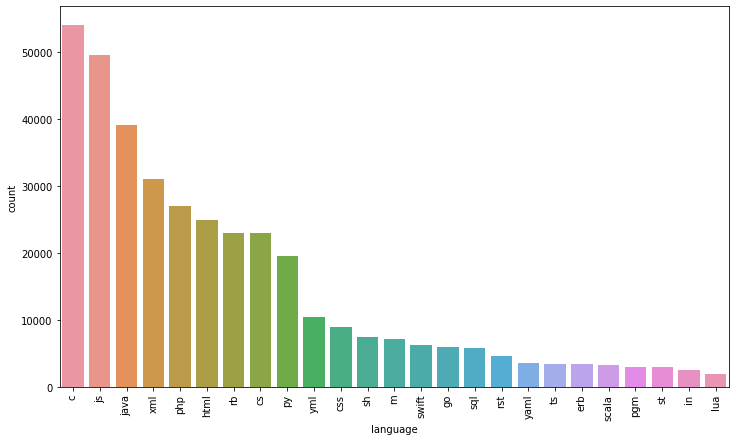

In [45]:
# visualise the top 25 languages
plt.figure(figsize=(12, 7))
sns.barplot(x=top_languages['language'], y=top_languages['count'])
plt.xticks(rotation=90)
plt.show()

### Cleaned Dataframe

In [46]:
code_df = df[df['type'].isin(top_languages['language'])]

In [47]:
number_of_rows = code_df.shape[0]
code_df = code_df.reset_index()
code_df.drop('index', axis=1, inplace=True)

In [48]:
code_df

,content,type
0,// Utility.cs\n//\n\nusing System;\nusing Syst...,cs
1,package io.mycat.backend.postgresql.packet;\r\...,java
2,TAPi18n._afterUILanguageChange = function() {\...,js
3,"filter:\n paths: [""src/*""]\ntools:\n ext...",yml
4,/**\n * \n */\npackage org.openrtb.dsp.intf.mo...,java
...,...,...
371750,c,c
371751,--\nDELETE FROM `conditions` WHERE `SourceType...,sql
371752,"/**\n * Copyright 2005-2016 Red Hat, Inc.\n *...",java
371753,c,c


#### Including only the top 75 language in the dataset
#### Filter the non-programming language content
Examples: IDE generated, data files(csv, txt, json), config files etc.

### The Machine Learning steps from here
1. Split the train and test data with pareto principle
2. Create vector for the text using Word2Vec (gensim.models)or BERT BiGRU
3. Selecting classifier.(Bert, RoBERTa (DL) and SG, SVM, Naive-Bayes, MLP (ML))

In [49]:
# x_train, x_test, y_train, y_test = train_test_split(code_df['content'], 
#                                                     code_df['type'], test_size=0.2, random_state=11)

In [ ]:
'''
tagged = []
faulty_index = []
# tags = []
for index in x_train.index:

    try:
        tokens = word_tokenize(x_train[index])
        tagged.append(TaggedDocument(words=tokens,  tags=y_train[index]))
        #tags.append(y_train[index])
    except:
        faulty_index.append(index)
'''

### Doc2Vec Vectorization model

In [8]:
''' code_snippet_model = Doc2Vec(vector_size=50, window=7, min_count=1, workers=6, epochs=10) '''

' code_snippet_model = Doc2Vec(vector_size=50, window=7, min_count=1, workers=6, epochs=10) '

#### Build vocabulary
Build vocabulary from a sequence of documents using tagged document objects

In [7]:
'''
code_snippet_model.build_vocab(tagged)
code_snippet_model.train(tagged, total_examples=code_snippet_model.corpus_count, epochs=10)
code_snippet_model.save('midnight_code_snippet_model')
'''

"\ncode_snippet_model.build_vocab(tagged)\ncode_snippet_model.train(tagged, total_examples=code_snippet_model.corpus_count, epochs=10)\ncode_snippet_model.save('midnight_code_snippet_model')\n"

#### Load the Doc2Vec model

In [55]:
code_snippet_model = Doc2Vec.load('midnight_code_snippet_model')

#### The magic of Doc2Vec

In [56]:
code_snippet_model.wv.most_similar('print')

[('System.out.println', 0.7512139081954956),
 ('echo', 0.7153032422065735),
 ('Console.WriteLine', 0.7130371332168579),
 ('var_dump', 0.688762903213501),
 ('\\n', 0.6711711287498474),
 ('console.log', 0.6666593551635742),
 ('puts', 0.6458790898323059),
 ('fmt.Println', 0.637239933013916),
 ('ws.send', 0.6342785358428955),
 ('assertEquals', 0.6133455038070679)]

In [57]:
code_snippet_model.wv.most_similar('if')

[('||', 0.7023719549179077),
 ('unless', 0.6616834998130798),
 ('elif', 0.6520282030105591),
 ('while', 0.6425095200538635),
 ('elseif', 0.6360433101654053),
 ('else', 0.6347188949584961),
 ('assert', 0.6156233549118042),
 ('ListUtil.listToArrayRemoveEmpty', 0.6135087013244629),
 ('responseText.indexOf', 0.6076799631118774),
 ('chrome.test.assertTrue', 0.5791233777999878)]

#### Vectors are transformed back to a dataframe
#### Stored in a dataframe and exported to a csv

In [3]:
'''
train_array = []
for index in x_train.index:
    
    if index not in faulty_index:

        train_vector = list(code_snippet_model.infer_vector(word_tokenize(x_train[index])))
        train_vector.append(y_train[index])
        train_array.append(train_vector)
    else:
        pass
'''

'\ntrain_array = []\nfor index in x_train.index:\n    \n    if index not in faulty_index:\n\n        train_vector = list(code_snippet_model.infer_vector(word_tokenize(x_train[index])))\n        train_vector.append(y_train[index])\n        train_array.append(train_vector)\n    else:\n        pass\n'

In [4]:
'''
cols = [x for x in range(0, 50)]
cols.append('lang')
train_df = pd.DataFrame(train_array, columns=cols)
train_df.to_csv('trained_vector', index=False) # trained vector 
'''

"\ncols = [x for x in range(0, 50)]\ncols.append('lang')\ntrain_df = pd.DataFrame(train_array, columns=cols)\ntrain_df.to_csv('trained_vector', index=False) # trained vector \n"

In [60]:
train_df = pd.read_csv('trained_vector')

In [61]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,lang
0,-0.057147,-0.051698,0.011729,-0.082089,-0.011450,-0.038587,-0.012985,0.069336,-0.014199,0.013881,...,0.045933,0.024880,-0.047050,0.008813,0.036911,0.093418,-0.050301,-0.013133,0.016538,c
1,0.068516,0.074142,0.023247,-0.443754,0.053480,0.083540,0.103227,0.513133,0.076389,-0.013970,...,-0.242868,0.112460,-0.003101,-0.075436,0.067696,0.374025,0.159639,-0.224017,-0.063501,rb
2,-0.033028,-0.026838,0.088610,0.045428,0.005419,0.064525,0.006845,0.233424,-0.120697,0.070785,...,-0.109145,0.067945,-0.065273,-0.039590,0.122663,0.147924,0.209696,-0.078442,-0.037185,rb
3,-0.032165,0.031722,0.076346,-0.113339,-0.258235,0.252573,0.167400,0.496314,-0.329236,0.061072,...,-0.311351,0.165247,-0.356933,0.093633,0.220023,0.388154,0.406436,-0.298847,0.093458,js
4,-0.077242,-0.041324,-0.013348,-0.042459,0.004981,-0.032884,0.025753,0.136845,0.002817,0.019040,...,0.025485,-0.020184,-0.073109,-0.020226,0.042971,0.004579,-0.008382,0.013740,0.000785,html
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297354,0.156326,0.119303,0.262036,-0.177478,0.170714,-0.040401,-0.028876,0.106615,0.023056,0.244373,...,-0.024945,-0.128967,-0.010665,-0.010022,0.051946,0.223022,0.210854,-0.083314,-0.070193,swift
297355,-0.102698,0.038244,0.221957,-0.121777,0.060921,0.018183,-0.014907,0.353902,-0.128001,-0.054795,...,-0.124142,0.063943,-0.160129,-0.028977,0.206803,0.255659,0.251010,-0.071276,0.041125,java
297356,0.146392,0.278310,0.312181,0.027481,-0.113026,0.146931,-0.150162,0.296914,-0.305322,-0.029789,...,-0.506594,-0.007527,0.094895,0.016231,0.511176,0.546895,0.432472,-0.158435,-0.236512,erb
297357,-0.000881,0.152843,0.154819,-0.071869,-0.001853,0.091876,-0.073366,0.167283,-0.116461,0.010070,...,-0.096387,0.011821,0.033876,0.060214,0.073908,0.263890,0.184410,0.015548,-0.054194,rb


In [62]:
from sklearn.linear_model import LogisticRegression

In [63]:
train_df.iloc[:, -1]

0             c
1            rb
2            rb
3            js
4          html
          ...  
297354    swift
297355     java
297356      erb
297357       rb
297358       js
Name: lang, Length: 297359, dtype: object

## to-do 
    1. label encode the languages in the above train_df
    2. re-train the model
    
    3. comment out the train part and do the following from the next time

       3.1 using pickle load the logistic regression model with name "code_recog_logistic_model.sav"
       3.2 pickle.load(open('code_recog_logistic_model.sav', 'rb'))
    4. pick random samples and test the data

In [64]:
logistic_regression = LogisticRegression(penalty='l2', solver='saga', max_iter=1000)
code_recog_model = logistic_regression.fit(train_df.iloc[:, :-1], train_df.iloc[:,-1])

### Saving the logistic regression model

In [65]:
pickle.dump(code_recog_model, open('code_recog_logistic_model.sav', 'wb'))

### Testing the logistic regression model

In [146]:
indices = np.random.randint(1, 1000, 20) # selecting 20 random indices

In [147]:
# vectorizing the code
test_vector = [] 
for index in indices:
    
    test_vector.append(code_snippet_model.infer_vector(word_tokenize(code_df['content'][index])))

code_recog_model.predict(test_vector)

array(['cs', 'java', 'js', 'c', 'js', 'c', 'ts', 'c', 'js', 'cs', 'yml',
       'php', 'xml', 'java', 'js', 'php', 'java', 'cs', 'rst', 'js'],
      dtype=object)

In [148]:
y_test = []
for i in indices:
    
    y_test.append(code_df['type'][i])

In [153]:
test_accuracy = code_recog_model.score(test_vector, y_test) 
print("Testing accuracy", test_accuracy*100, "%")

Testing accuracy 90.0 %
